In [38]:
## Importing packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans, MeanShift
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import export_graphviz
import pydot
import statsmodels.api as sm
from scipy import stats

## Setting Seaborn Styles
dims = (11.7, 8.27)
sns.set(style='ticks')
sns.set_palette((sns.color_palette('colorblind', 8)))
sns.set(rc={'figure.figsize':dims})
%matplotlib inline

## Setting random seed
np.random.seed(1000)

In [4]:
## Import data to dataframes

## Base directory for data
basedir = 'E:\Syracuse\IST707\Project\google-play-store-apps'

playstoredata = pd.read_csv(basedir + '\googleplaystore.csv')

# Cleaning data

In [5]:
## Dropping the following
### 10472: Data types are inconsistent with established types
### 9148: Incomplete values in row
droprow = [10472, 9148]

try:
    playstoredata.drop(index=droprow, axis=0, inplace=True)
    playstoredata = playstoredata.reset_index(drop=True)
except:
    print('Records on rows {} already dropped.'.format(droprow))


In [6]:
## Iterating over the DF and standardizing the Size column to Megabytes
for index, row in playstoredata.iterrows():
    rownum = index + 1
    if 'k' in row['Size']:
        playstoredata.iloc[index, 4] = float(row['Size'].replace('k', '')) / 1000
    elif 'M' in row['Size']:
        playstoredata.iloc[index, 4] = row['Size'].replace('M', '')
    else:
        playstoredata.iloc[index, 4] = 0
        

In [7]:
## Removing the dollar size from the price
try: 
    playstoredata['Price'] = playstoredata['Price'].map(lambda x: x.replace('$', ''))
except:
    print('No $ found in Price column.')

## Making the Reviews and Installs columns numeric for ease of manipulation
playstoredata['Reviews'] = pd.to_numeric(playstoredata['Reviews'])
playstoredata['Installs'] = pd.to_numeric(playstoredata['Installs'].replace('\+|,', '', regex=True))
playstoredata['Size'] = playstoredata['Size'].astype('float')
playstoredata['Price'] = playstoredata['Price'].astype('float')
playstoredata['Last Updated'] = pd.to_datetime(playstoredata['Last Updated'])


In [8]:
## Storing some variables for later use
total_records = len(playstoredata)

## Gather some lists of unique values from the dataframe
categories = playstoredata['Category'].unique()
genres = playstoredata['Genres'].unique()
types = playstoredata['Type'].unique()
apps = playstoredata['App'].unique()
contentrating = playstoredata['Content Rating'].unique()
genre = list(set(';'.join(playstoredata['Genres'].unique()).split(';')))
years = playstoredata['Last Updated'].dt.year.unique()
types = playstoredata['Type'].unique()

In [9]:
## Translating some variables into integers for model processing
### Category
category_mapping = {}
for i in range(0,len(categories)):
    category_mapping[categories[i]] = i
playstoredata["CategoryInt"] = playstoredata["Category"].map(category_mapping).astype(int)

### Last Update
update_mapping = {}
for i in range(0, len(years)):
    update_mapping[years[i]] = i
playstoredata["Last Update Year"] = playstoredata["Last Updated"].dt.year
playstoredata["YearsSinceLastUpdate"] = playstoredata["Last Update Year"].map(update_mapping).astype(int)


### Type
type_mapping = {}
for i in range(0,len(types)):
    type_mapping[types[i]] = i
playstoredata["TypesInt"] = playstoredata["Type"].map(type_mapping).astype(int)


print('Categories:\n{} \n\n'.format(category_mapping))
print('Last Update Year:\n{} \n\n'.format(update_mapping))
print('App Type:\n {}'.format(type_mapping))

Categories:
{'ART_AND_DESIGN': 0, 'AUTO_AND_VEHICLES': 1, 'BEAUTY': 2, 'BOOKS_AND_REFERENCE': 3, 'BUSINESS': 4, 'COMICS': 5, 'COMMUNICATION': 6, 'DATING': 7, 'EDUCATION': 8, 'ENTERTAINMENT': 9, 'EVENTS': 10, 'FINANCE': 11, 'FOOD_AND_DRINK': 12, 'HEALTH_AND_FITNESS': 13, 'HOUSE_AND_HOME': 14, 'LIBRARIES_AND_DEMO': 15, 'LIFESTYLE': 16, 'GAME': 17, 'FAMILY': 18, 'MEDICAL': 19, 'SOCIAL': 20, 'SHOPPING': 21, 'PHOTOGRAPHY': 22, 'SPORTS': 23, 'TRAVEL_AND_LOCAL': 24, 'TOOLS': 25, 'PERSONALIZATION': 26, 'PRODUCTIVITY': 27, 'PARENTING': 28, 'WEATHER': 29, 'VIDEO_PLAYERS': 30, 'NEWS_AND_MAGAZINES': 31, 'MAPS_AND_NAVIGATION': 32} 


Last Update Year:
{2018: 0, 2017: 1, 2014: 2, 2016: 3, 2015: 4, 2013: 5, 2012: 6, 2011: 7, 2010: 8} 


App Type:
 {'Free': 0, 'Paid': 1}


# Preprocessing and Model Runs with Outliers Included

In [44]:
## Some ratings don't exist. So we're only going to take the records that do have ratings
playstore_finit = playstoredata[np.isfinite(playstoredata['Rating'])]

## Splitting the train data into train/test using an 80/20 split
exclude_cols = ['App', 'Last Updated', 'Current Ver', 'Android Ver', 'Category', 'Type', 'Content Rating',
                'Genres', 'Last Update Year']
X_train, X_test, Y_train, Y_test = train_test_split(
    playstore_finit.loc[:, playstore_finit.columns != 'Rating'], playstore_finit.loc[:, playstore_finit.columns == 'Rating'],
    test_size=0.2, random_state=1000)
X_train.drop(exclude_cols, axis=1, inplace=True)
X_test.drop(exclude_cols, axis=1, inplace=True)
X_cols_noout = X_train_noout.columns.tolist()
print(X_train.describe())


            Reviews         Size      Installs        Price  CategoryInt  \
count  7.492000e+03  7492.000000  7.492000e+03  7492.000000  7492.000000   
mean   5.231553e+05    18.968323  1.865047e+07     0.827329    17.771757   
std    3.166676e+06    23.098162  9.417873e+07    13.958431     7.341506   
min    1.000000e+00     0.000000  1.000000e+00     0.000000     0.000000   
25%    1.880000e+02     2.300000  1.000000e+04     0.000000    13.750000   
50%    6.146500e+03     9.400000  5.000000e+05     0.000000    18.000000   
75%    8.430950e+04    27.000000  5.000000e+06     0.000000    23.000000   
max    7.815831e+07   100.000000  1.000000e+09   400.000000    32.000000   

       YearsSinceLastUpdate     TypesInt  
count           7492.000000  7492.000000  
mean               0.649493     0.069941  
std                1.240399     0.255065  
min                0.000000     0.000000  
25%                0.000000     0.000000  
50%                0.000000     0.000000  
75%           

In [33]:
Y_train = np.array(Y_train).ravel()
Y_test = np.array(Y_test).ravel()

In [35]:
print(X_train.head(n=1))
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_train[1])

      Reviews  Size  Installs  Price  CategoryInt  YearsSinceLastUpdate  \
6543       31   2.3      1000    0.0           16                     0   

      TypesInt  
6543         0  
[-0.14173418  0.26114977 -0.18742714 -0.05927488 -1.87600153 -0.52365114
 -0.27422786]


C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


In [47]:
## Compiling and fitting model
rf_model = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=1000,
                                 min_samples_leaf=1, verbose=1)
rf_fit = rf_model.fit(X_train, Y_train)
rf_pred = rf_model.predict(X_test)
rf_score = rf_model.score(X_test, Y_test)

print(rf_score)

C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend Th

0.17823407360013788


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


In [48]:
print(sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), X_cols), 
             reverse=True))

[(0.3533, 'Reviews'), (0.2652, 'Size'), (0.1735, 'CategoryInt'), (0.1093, 'Installs'), (0.0689, 'YearsSinceLastUpdate'), (0.0244, 'Price'), (0.0054, 'TypesInt')]


In [49]:
# Pull out one tree from the forest
tree = rf_model.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'outliers_tree.dot', feature_names = X_cols, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('outliers_tree.dot')

# Write graph to a png file
graph.write_png('outliers_tree.png')

In [14]:
# K Means Clustering
km_model = KMeans(n_clusters=8, n_init=10, random_state=1000, n_jobs=-1)
km_fit = km_model.fit(X_train, Y_train)
km_pred = km_model.predict(X_test)
km_score = km_model.score(X_test, Y_test)
print(km_score)


-2644.2168878013385


In [15]:
# Mean Shift
ms_model = MeanShift(n_jobs=3)
ms_fit = ms_model.fit(X_train, Y_train)
ms_pred = ms_model.predict(X_test)

In [16]:
ms_mse = mean_squared_error(y_true=Y_test, y_pred=ms_pred)
ms_mae = mean_absolute_error(y_true=Y_test, y_pred=ms_pred)
print(ms_mse)
print(ms_mae)

17.10636606189968
4.082337246531483


In [30]:
## Linear Regression
lr_model = LinearRegression(normalize=True, n_jobs=3)
lr_fit = lr_model.fit(X_train, Y_train)
lr_pred = lr_model.predict(X_test)
lr_score = lr_model.score(X_test, Y_test)
lr_mse = mean_squared_error(y_true=Y_test, y_pred=lr_pred)
lr_mae = mean_absolute_error(y_true=Y_test, y_pred=lr_pred)
print(lr_score)
print(lr_mse)
print(lr_mae)

tsr_model = TheilSenRegressor(tol=1e-6, n_subsamples=160, random_state=True, n_jobs=3)
tsr_fit = tsr_model.fit(X_train, Y_train)
tsr_pred = tsr_model.predict(X_test)
tsr_score = tsr_model.score(X_test, Y_test)
tsr_mse = mean_squared_error(y_true=Y_test, y_pred=tsr_pred)
tsr_mae = mean_absolute_error(y_true=Y_test, y_pred=tsr_pred)
print(tsr_score)
print(tsr_mse)
print(tsr_mae)


0.028248975036268775
0.2658833263641762
0.3550426042145483
0.017304319610344843
0.2688779220124422
0.3554899772560261


In [18]:
# K Nearest Neighbor
knn_model = KNeighborsRegressor(n_neighbors=7, p=2, n_jobs=3)
knn_fit = knn_model.fit(X_train, Y_train)
knn_pred = knn_model.predict(X_test)
knn_score = knn_model.score(X_test, Y_test)
print(knn_score)

0.02020361470543064


In [19]:
# Neural Network
nn_model = MLPRegressor(hidden_layer_sizes=50, activation='tanh', alpha=0.01, max_iter=200)
nn_fit = nn_model.fit(X_train, Y_train)
nn_pred = nn_model.predict(X_test)
nn_score = nn_model.score(X_test, Y_test)
print(nn_score)

0.0520046994788137


In [20]:
## SVM SVR
svr_model = SVR(tol=1e-4, C=1.0, verbose=1)
svr_fit = svr_model.fit(X_train, Y_train)
svr_pred = svr_model.predict(X_test)
svr_score = svr_model.score(X_test, Y_test)
print(svr_score)

[LibSVM]0.012907257540140105


# Preprocessing and Model Runs with No Outliers Included

In [21]:
playstore_nooutliers = playstore_finit
## Only keeping rows with prices <= 50
playstore_nooutliers = playstore_nooutliers.query('Price <= 50')
## Only keeping rows with less than 100M installs
playstore_nooutliers = playstore_nooutliers.query('Installs <= 100000000')
## Dropping categories with fewer than 100 rows
playstore_nooutliers = playstore_nooutliers[~playstore_nooutliers['CategoryInt'].isin([2, 28, 5, 10, 0, 29, 15, 1, 14])]


In [42]:
exclude_cols = ['App', 'Last Updated', 'Current Ver', 'Android Ver', 'Category', 'Type', 'Content Rating',
                'Genres', 'Last Update Year']
X_train_noout, X_test_noout, Y_train_noout, Y_test_noout = train_test_split(
    playstore_nooutliers.loc[:, playstore_nooutliers.columns != 'Rating'],
    playstore_nooutliers.loc[:, playstore_nooutliers.columns == 'Rating'],
    test_size=0.2, random_state=1000)
X_train_noout.drop(exclude_cols, axis=1, inplace=True)
X_test_noout.drop(exclude_cols, axis=1, inplace=True)
X_cols_noout = X_train_noout.columns.tolist()
X_test2 = X_test_noout

Y_train_noout = np.array(Y_train_noout).ravel()
Y_test_noout = np.array(Y_test_noout).ravel()

In [23]:
print(X_test2.describe())

            Reviews         Size      Installs        Price  CategoryInt  \
count  1.735000e+03  1735.000000  1.735000e+03  1735.000000  1735.000000   
mean   2.931879e+05    19.318542  8.131313e+06     0.294403    18.334294   
std    1.248049e+06    23.512887  2.196859e+07     1.782262     7.055886   
min    1.000000e+00     0.000000  1.000000e+01     0.000000     3.000000   
25%    2.390000e+02     2.400000  1.000000e+04     0.000000    16.000000   
50%    6.925000e+03     9.400000  5.000000e+05     0.000000    18.000000   
75%    8.288250e+04    27.500000  5.000000e+06     0.000000    24.000000   
max    2.313478e+07   100.000000  1.000000e+08    33.990000    32.000000   

       YearsSinceLastUpdate     TypesInt  
count           1735.000000  1735.000000  
mean               0.713545     0.063401  
std                1.278117     0.243752  
min                0.000000     0.000000  
25%                0.000000     0.000000  
50%                0.000000     0.000000  
75%           

In [24]:
scaler2 = StandardScaler()
scaler2.fit(X_train_noout)

X_train_noout = scaler2.transform(X_train_noout)
X_test_noout = scaler2.transform(X_test_noout)

C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """


In [50]:
## Compiling and fitting model
rf_model_noout = RandomForestRegressor(n_jobs=-1, n_estimators=800, random_state=1000,
                                 min_samples_leaf=1, criterion='mse', verbose=1)
rf_fit_noout = rf_model_noout.fit(X_train_noout, Y_train_noout)
rf_pred_noout = rf_model_noout.predict(X_test_noout)
rf_score_noout = rf_model_noout.score(X_test_noout, Y_test_noout)

print(rf_score_noout)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Par

0.1939236322696526


In [60]:
print(sorted(zip(map(lambda x: round(x, 4), rf_model_noout.feature_importances_), X_cols_noout), 
             reverse=True))

[(0.367, 'Reviews'), (0.2724, 'Size'), (0.1833, 'CategoryInt'), (0.0984, 'Installs'), (0.0543, 'YearsSinceLastUpdate'), (0.0204, 'Price'), (0.0042, 'TypesInt')]


In [31]:
## Linear Regression
lr_model_noout = LinearRegression(normalize=True, n_jobs=3)
lr_fit_noout = lr_model_noout.fit(X_train_noout, Y_train_noout)
lr_pred_noout = lr_model_noout.predict(X_test_noout)
lr_score_noout = lr_model_noout.score(X_test_noout, Y_test_noout)
lr_mse_noout = mean_squared_error(y_true=Y_test_noout, y_pred=lr_pred_noout)
lr_mae_noout = mean_absolute_error(y_true=Y_test_noout, y_pred=lr_pred_noout)
print(lr_score_noout)
print(lr_mse_noout)
print(lr_mae_noout)

tsr_model_noout = TheilSenRegressor(tol=1e-6, n_subsamples=160, random_state=True, n_jobs=3)
tsr_fit_noout = tsr_model_noout.fit(X_train_noout, Y_train_noout)
tsr_pred_noout = tsr_model_noout.predict(X_test_noout)
tsr_score_noout = tsr_model_noout.score(X_test_noout, Y_test_noout)
tsr_mse_noout = mean_squared_error(y_true=Y_test_noout, y_pred=tsr_pred_noout)
tsr_mae_noout = mean_absolute_error(y_true=Y_test_noout, y_pred=tsr_pred_noout)
print(tsr_score_noout)
print(tsr_mse_noout)
print(tsr_mae_noout)


0.05031809974711643
0.25471432530282
0.3455149611679629
0.050459504060646476
0.25467639923062035
0.34518622840952184


In [27]:
# Neural Network
nn_model_noout = MLPRegressor(hidden_layer_sizes=50, activation='tanh', alpha=0.01, max_iter=200)
nn_fit_noout = nn_model_noout.fit(X_train_noout, Y_train_noout)
nn_pred_noout = nn_model_noout.predict(X_test_noout)
nn_score_noout = nn_model_noout.score(X_test_noout, Y_test_noout)
print(nn_score_noout)

0.06580952892827174


In [ ]:
## SVM SVR
svr_model_noout = SVR(kernel='linear', tol=1e-4, C=1.0, verbose=1)
svr_fit_noout = svr_model_noout.fit(X_train_noout, Y_train_noout)
svr_pred_noout = svr_model_noout.predict(X_test_noout)
svr_score_noout = svr_model_noout.score(X_test_noout, Y_test_noout)
print(svr_score_noout)

[LibSVM]

-2.225634915942395e+16


C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


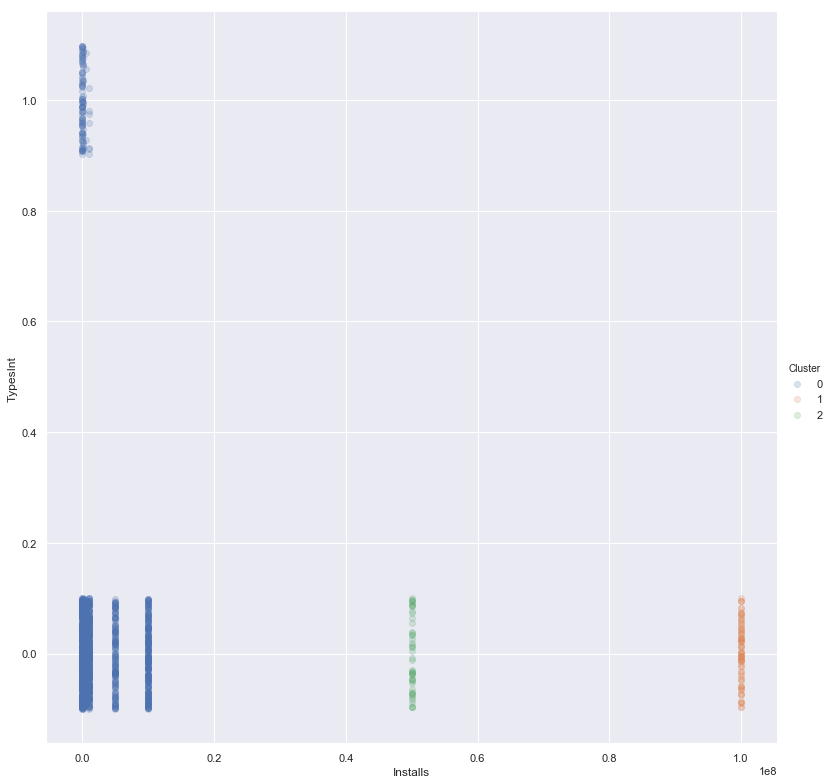

In [74]:
# K Means Clustering
km_model_noout = KMeans(n_clusters=3, n_init=25, random_state=1000, n_jobs=-1)
km_fit_noout = km_model_noout.fit(X_train_noout, Y_train_noout)
km_pred_noout = km_model_noout.predict(X_test_noout)
km_score_noout = km_model_noout.score(X_test_noout, Y_test_noout)
print(km_score_noout)

result = pd.concat([X_test2.reset_index(drop=True), pd.DataFrame(Y_test_noout, columns=['Rating']),
                    pd.DataFrame(km_pred_noout, columns=['Cluster'])], axis=1, sort=False)

sns.lmplot(x='Installs', y='TypesInt', data=result, hue='Cluster', fit_reg=False, x_jitter=.1, y_jitter=.1,
           scatter_kws={'alpha': 0.2}, size=11)

# Calculating per Category

In [315]:
playstore_experiment = playstore_finit
## Only keeping rows with prices <= 50
playstore_experiment = playstore_experiment.query('Price <= 50')
## Only keeping rows with less than 100M installs
playstore_experiment = playstore_experiment.query('Installs <= 100000000')

exclude_cols = ['App', 'Last Updated', 'Current Ver', 'Android Ver', 'Category', 'Type', 'Content Rating',
                'Genres', 'Last Update Year']

for cat in categories:
    print(cat)
    mapped_cat = category_mapping[cat]
    data = playstore_experiment.query('CategoryInt == "{}"'.format(mapped_cat))
    X_train, X_test, Y_train, Y_test = train_test_split(
        data.loc[:, data.columns != 'Rating'], data.loc[:, data.columns == 'Rating'], test_size=0.2, random_state=1000)
    X_train.drop(exclude_cols, axis=1, inplace=True)
    X_test.drop(exclude_cols, axis=1, inplace=True)
    Y_train = np.array(Y_train).ravel()
    Y_test = np.array(Y_test).ravel()

    #scaler = StandardScaler()
    #scaler.fit(X_train_noout)
    #X_train = scaler2.transform(X_train)
    #X_test = scaler2.transform(X_test)
    
    ## Linear Regression
    lr_model = LinearRegression(normalize=True, n_jobs=3)
    lr_fit = lr_model.fit(X_train, Y_train)
    lr_pred = lr_model.predict(X_test)
    lr_score = lr_model.score(X_test, Y_test)
    lr_mse = mean_squared_error(y_true=Y_test, y_pred=lr_pred)
    lr_mae = mean_absolute_error(y_true=Y_test, y_pred=lr_pred)
    print('LR R-Squared: {}'.format(round(lr_score,4)))
    ## Compiling and fitting model
    rf_model = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=1000,
                                 min_samples_leaf=1)
    rf_fit = rf_model.fit(X_train, Y_train)
    rf_pred = rf_model.predict(X_test)
    rf_score = rf_model.score(X_test, Y_test)

    print('RF R-Squared: {}'.format(round(rf_score,4)))
    print('\r')

ART_AND_DESIGN
LR R-Squared: -0.0505
RF R-Squared: 0.0127

AUTO_AND_VEHICLES
LR R-Squared: 0.0093
RF R-Squared: -0.2762

BEAUTY
LR R-Squared: -0.4994
RF R-Squared: -0.0887

BOOKS_AND_REFERENCE
LR R-Squared: -0.2009
RF R-Squared: 0.0366

BUSINESS
LR R-Squared: 0.062
RF R-Squared: 0.0765

COMICS
LR R-Squared: 0.0911
RF R-Squared: -0.2174

COMMUNICATION
LR R-Squared: 0.0179
RF R-Squared: -0.4665

DATING
LR R-Squared: 0.1221
RF R-Squared: 0.7449

EDUCATION
LR R-Squared: 0.0958
RF R-Squared: 0.0557

ENTERTAINMENT
LR R-Squared: -0.0287
RF R-Squared: -0.2677

EVENTS
LR R-Squared: 0.1301
RF R-Squared: -0.5541

FINANCE
LR R-Squared: -0.058
RF R-Squared: 0.0141

FOOD_AND_DRINK
LR R-Squared: -0.1777
RF R-Squared: 0.1427

HEALTH_AND_FITNESS
LR R-Squared: 0.0975
RF R-Squared: 0.2372

HOUSE_AND_HOME
LR R-Squared: -0.4098
RF R-Squared: -0.8558

LIBRARIES_AND_DEMO
LR R-Squared: 0.3249
RF R-Squared: 0.1907

LIFESTYLE
LR R-Squared: -0.3837
RF R-Squared: 0.0248

GAME
LR R-Squared: 0.0949
RF R-Squared: 0.

# Visualizations

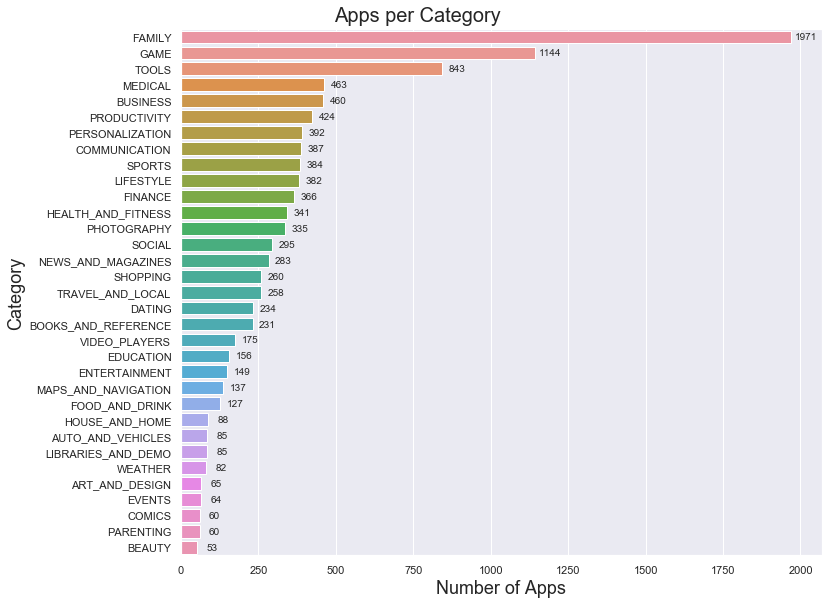

In [179]:
## Bar chart distribution of categories, sorted by number of records
category_count = {}
for cat in categories:
    category_count[cat] = (len(playstoredata.query('Category == "{}"'.format(cat))))
    
category_count = sorted(category_count.items(), key=lambda x: x[1], reverse=True)
category_count = dict((x,y) for x, y in category_count)

fig1, ax1 = plot.subplots(figsize=dims)
plot1 = sns.barplot(x=list(category_count.values()), y=list(category_count.keys()), ax=ax1)
fig1.suptitle('Apps per Category', fontsize=20, y=1.01)
ax1.set_ylabel('Category', fontsize=18)
ax1.set_xlabel('Number of Apps', fontsize=18)
rects = ax1.patches
for rect, label in zip (rects, list(category_count.values())):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    plot.annotate(label, (x_value, y_value), xytext=(15,0), textcoords='offset points', va='center', ha='center')
plot.tight_layout()

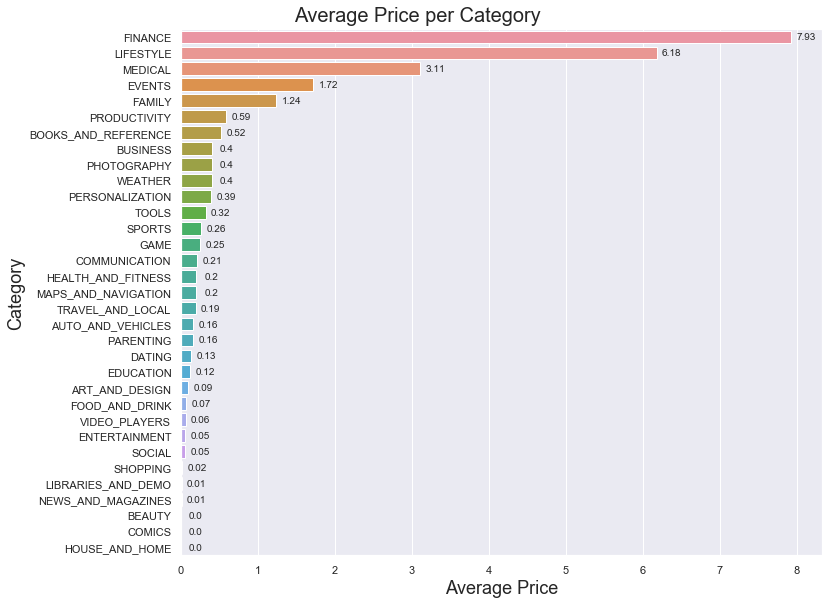

In [180]:
## Avg price per category
category_price = {}
for cat in categories:
    category_price[cat] = round(playstoredata['Price'][playstoredata['Category'] == cat].mean(),2)
    
category_price = sorted(category_price.items(), key=lambda x: x[1], reverse=True)
category_price = dict((x,y) for x, y in category_price)

fig2, ax2 = plot.subplots(figsize=dims)
plot2 = sns.barplot(x=list(category_price.values()), y=list(category_price.keys()))
fig2.suptitle('Average Price per Category', fontsize=20, y=1.01)
ax2.set_ylabel('Category', fontsize=18)
ax2.set_xlabel('Average Price', fontsize=18)

rects = ax2.patches
for rect, label in zip (rects, list(category_price.values())):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    plot.annotate(label, (x_value, y_value), xytext=(15,0), textcoords='offset points', va='center', ha='center')
plot.tight_layout()

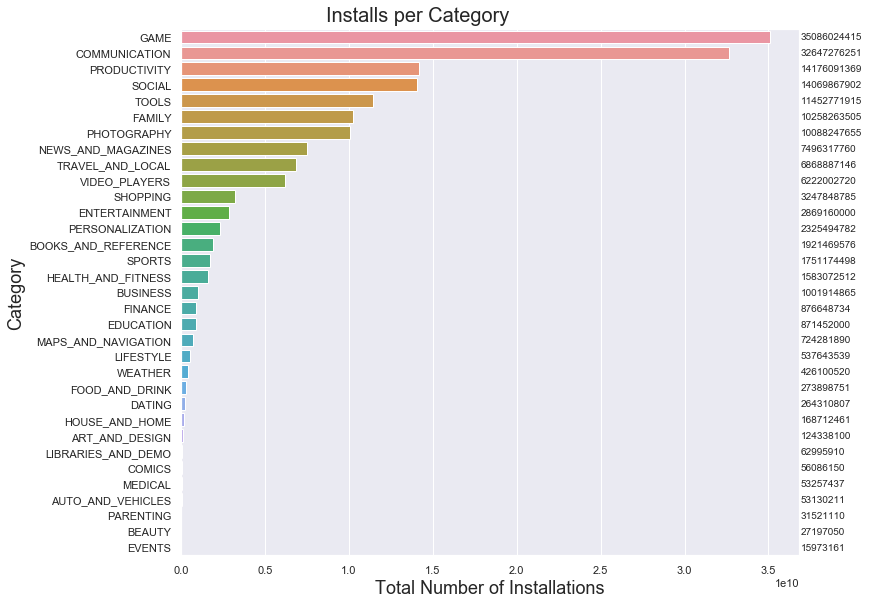

In [181]:
## Bar chart distribution of categories, sorted by number of records
category_installs = {}
for cat in categories:
    category_installs[cat] = round(playstoredata['Installs'][playstoredata['Category'] == cat].sum(),2)
    
category_installs = sorted(category_installs.items(), key=lambda x: x[1], reverse=True)
category_installs = dict((x,y) for x, y in category_installs)

fig9, ax9 = plot.subplots(figsize=dims)
plot9 = sns.barplot(x=list(category_installs.values()), y=list(category_installs.keys()), ax=ax9)
fig9.suptitle('Installs per Category', fontsize=20, y=1.01)
ax9.set_ylabel('Category', fontsize=18)
ax9.set_xlabel('Total Number of Installations', fontsize=18)
rects = ax1.patches
for rect, label in zip (rects, list(category_installs.values())):
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    plot.annotate(label, (x_value, y_value), xytext=(620,0), textcoords='offset points', va='center', ha='left')
plot.tight_layout()

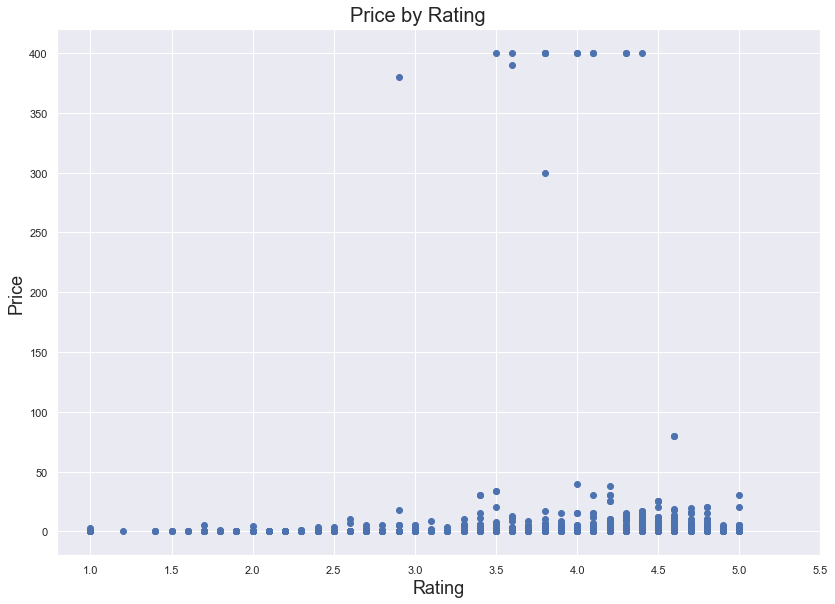

In [182]:
## Scatter plot of price vs rating
price = playstoredata['Price']
rating = playstoredata['Rating']

fig3, ax3 = plot.subplots(figsize=dims)
plot.scatter(x=rating, y=price)
plot.xticks(np.arange(min(rating), max(rating)+1, 0.5))
fig3.suptitle('Price by Rating', fontsize=20, y=1.01)
ax3.set_ylabel('Price', fontsize=18)
ax3.set_xlabel('Rating', fontsize=18)
plot.tight_layout()

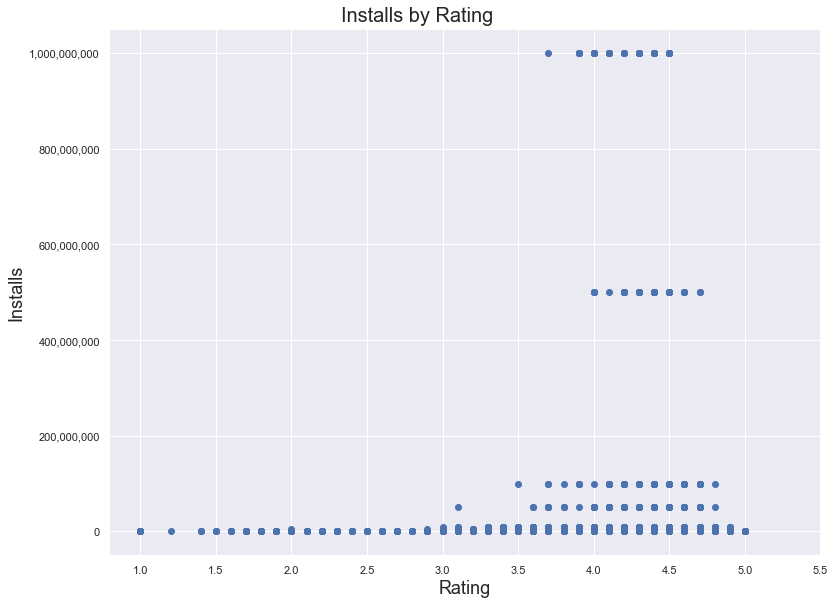

In [183]:
## Scatter plot of installs vs rating
installs = playstoredata['Installs']
rating = playstoredata['Rating']

fig4, ax4 = plot.subplots(figsize=dims)
plot.scatter(x=rating, y=installs)
plot.xticks(np.arange(min(rating), max(rating)+1, 0.5))
fig4.suptitle('Installs by Rating', fontsize=20, y=1.01)
ax4.set_ylabel('Installs', fontsize=18)
ax4.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax4.set_xlabel('Rating', fontsize=18)
plot.tight_layout()

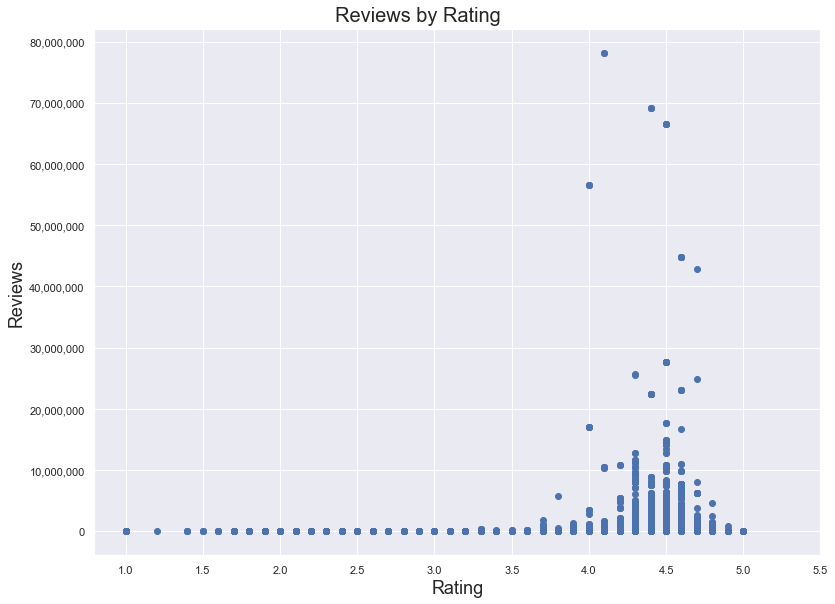

In [184]:
## Scatter plot of reviews vs rating
reviews = playstoredata['Reviews']
rating = playstoredata['Rating']

fig5, ax5 = plot.subplots(figsize=dims)
plot.scatter(x=rating, y=reviews)
plot.xticks(np.arange(min(rating), max(rating)+1, 0.5))
fig5.suptitle('Reviews by Rating', fontsize=20, y=1.01)
ax5.set_ylabel('Reviews', fontsize=18)
ax5.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax5.set_xlabel('Rating', fontsize=18)
plot.tight_layout()

C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


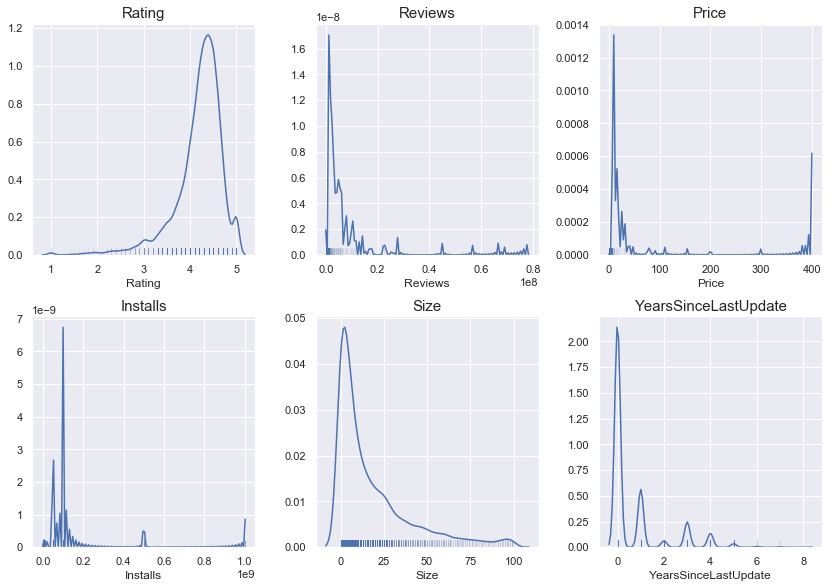

In [338]:
## Basic histograms
hist_plots = ['Rating', 'Reviews', 'Price', 'Installs', 'Size', 'YearsSinceLastUpdate' ]
fig6, ax6 = plot.subplots(nrows=2, ncols=3, figsize=dims)
count = 0
for i in range(0,2):
    for j in range(0,3):
        ax = ax6[i][j]
        
        if count < len(hist_plots):
            #ax.hist(playstoredata[hist_plots[count]], bins)
            sns.distplot(a=playstoredata[hist_plots[count]], bins=10, rug=True, hist=False, 
                         kde=True, rug_kws={'height': 0.03, 'alpha': 0.01},ax=ax)
            ax.set_title(hist_plots[count], fontsize=15)
        else:
            ax.set_axis_off()
        count += 1
#fig6.suptitle('Distribution of data', fontsize=20, y=1.01)
plot.tight_layout()

C:\Users\Menca\AppData\Local\conda\conda\envs\IST707\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


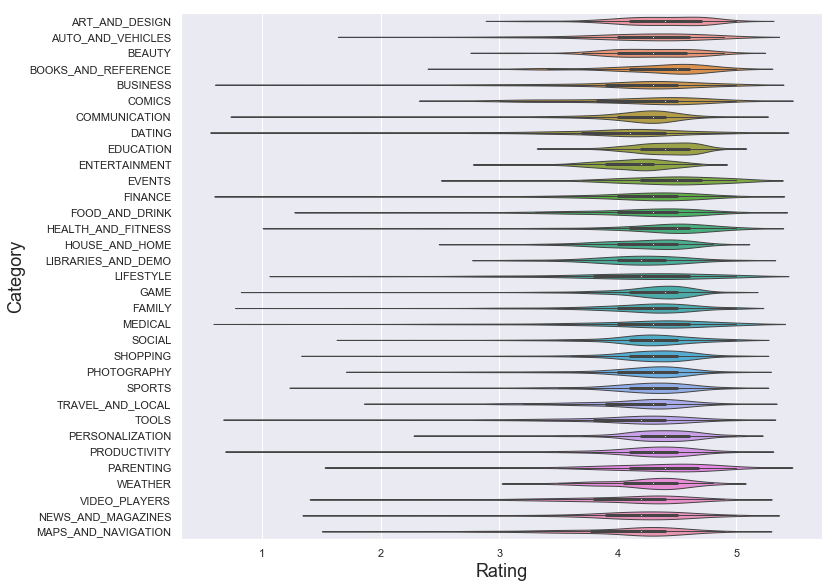

In [337]:
## Violin Plots
fig7, ax7 = plot.subplots(figsize=dims)
sns.violinplot(x=playstoredata['Rating'], y=playstoredata['Category'], linewidth=1)
#fig7.suptitle('Violin Plot (Rating by Category)', fontsize=20, y=1.01)
ax7.set_ylabel('Category', fontsize=18)
ax7.set_xlabel('Rating', fontsize=18)
plot.tight_layout()

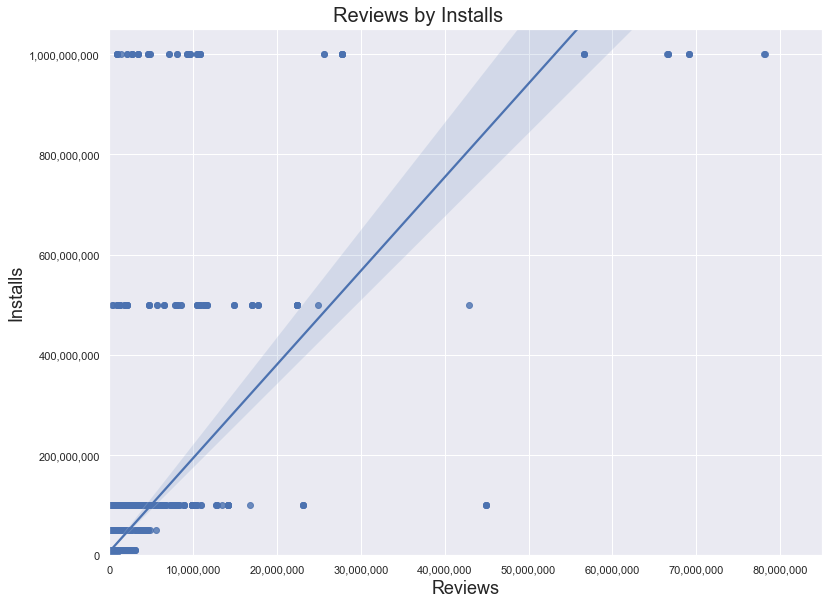

In [187]:
## Scatter plot of price vs rating
reviews = playstoredata['Reviews']
installs = playstoredata['Installs']

fig8, ax8 = plot.subplots(figsize=dims)
sns.regplot(y='Installs', x='Reviews', data=playstoredata, ax=ax8)
fig8.suptitle('Reviews by Installs', fontsize=20, y=1.01)
ax8.set_xlabel('Reviews', fontsize=18)
ax8.set_ylabel('Installs', fontsize=18)
ax8.set_ylim(0,1050000000)
ax8.set_xlim(0,85000000)
ax8.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax8.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plot.tight_layout()

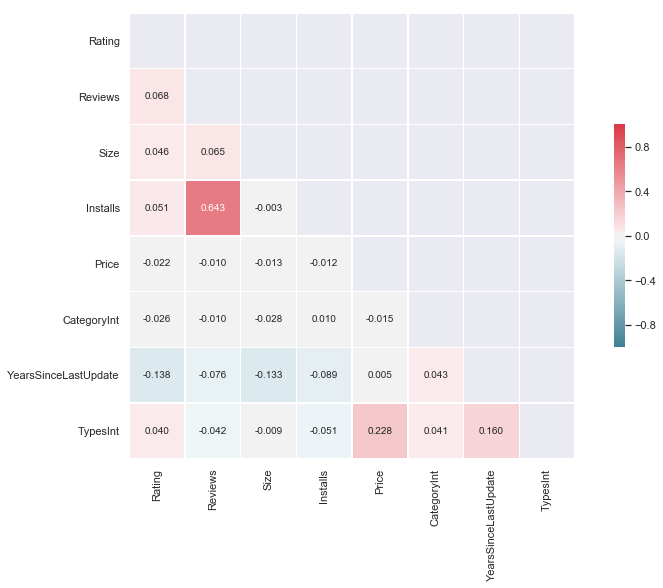

In [336]:
## Creating the correlation df
corr_df = playstoredata.copy()

## Dropping columns that don't make sense to correlate
corr_dropcols = [ 'Last Update Year' ]
corr_df.drop(corr_dropcols, axis=1, inplace=True)
correlation = corr_df.corr()

## Creating the mask so it's halved.
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
## Color map
cmap = sns.diverging_palette(220, 10, n=20, as_cmap=True)

fig7, ax7 = plot.subplots(figsize=dims)
sns.heatmap(data=correlation, mask=mask, cmap=cmap, square=True, linewidths=0.5, fmt='.3f', center=0,
            cbar_kws={"shrink": .5}, vmin=-1, vmax=1, annot=True, cbar=True, ax=ax7)
#fig7.suptitle('Correlation Matrix', fontsize=20, y=1.01)
plot.tight_layout()